In [1]:
import os
import re
import sls
import PIL
import sys
import glob
import json
import time
import timm
import math
import copy
import torch
import pickle
import logging
import fnmatch
import argparse
import itertools
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
from apex import amp
import seaborn as sns
import albumentations
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from copy import deepcopy
import scikitplot as skplt
from sklearn import metrics
import torch.optim as optim
from timm import create_model
from datetime import datetime
from timm.data.loader import *
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from cutmix.cutmix import CutMix
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
#from pytorch_metric_learning import loss
import torch.utils.model_zoo as model_zoo
from timm.models.layers.activations import *
from timm.utils import accuracy, AverageMeter
%config InlineBackend.figure_format = 'retina'
from apex.parallel import convert_syncbn_model
#from timm.utils import ApexScaler, NativeScaler
from cutmix.utils import CutMixCrossEntropyLoss
from timm.models.registry import register_model
from timm.models.helpers import load_pretrained
from collections import OrderedDict, defaultdict
from torch.utils.tensorboard import SummaryWriter
from warmup_scheduler import GradualWarmupScheduler
from timm.models.resnet import resnet26d, resnet50d
from knockknock import email_sender, telegram_sender
from torchvision import transforms, models, datasets
from timm.models.helpers import build_model_with_cfg
from torch.utils.data.sampler import SubsetRandomSampler
from randaugment import RandAugment, ImageNetPolicy, Cutout
from apex.parallel import DistributedDataParallel as ApexDDP
#from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.models.efficientnet import efficientnet_b0, efficientnet_b1, efficientnet_b2, efficientnet_b3
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_curve, auc, roc_auc_score
#from timm.data import Dataset, DatasetTar, RealLabelsImagenet, create_loader, Mixup, FastCollateMixup, AugMixDataset

In [2]:
data_dir = '/home/linh/Downloads/DeepWeeds/'
device = torch.device("cuda:1")
batch_size=30
lr=0.01
step_size=30
# Define your transforms for the training and testing sets
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomRotation(30),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

# Using the image datasets and the trainforms, define the data_loader
# batch_size = 64 for EfficientNet from B0 - B3
# batch_size = 32 for EfficientNet B4, B5
# batch_size = 16 for EfficientNet_B6
# batch_size = 8 for EfficientNet_B7
# batch_size = 32 for MixNet_s

data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4, pin_memory = True)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

print(dataset_sizes)
print(device)

"""# Label mapping
with open('/home/linh/Downloads/Derma/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)"""


'''f = open('/home/linh/Downloads/Derma/classes.txt','r')
cat_to_name = f.read()
print(cat_to_name)
f.close()
'''
### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['train'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}

    
# Run this to test the data loader
images, labels = next(iter(data_loader['val']))
images.size()

{'train': 64125, 'val': 21375, 'test': 3502}
cuda:1


torch.Size([30, 3, 224, 224])

In [3]:
#model = EfficientNet.from_pretrained('efficientnet-b3')
model = timm.create_model('tf_efficientnet_b4', pretrained=True, 
                     drop_rate=0.4, drop_path_rate=0.4, drop_connect_rate=0.4)
#from efficientnet_pytorch import EfficientNet
#model = EfficientNet.from_pretrained('efficientnet-b6')
# Create classifier
for param in model.parameters():
    param.requires_grad = True
n_classes = 9
model.classifier = nn.Linear(model.classifier.in_features, n_classes+1)

criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
#optimizer = sls.Sls(model.parameters())
#optimizer = sls.Sls(model.parameters(), n_batches_per_epoch=len(data_loader['train']))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print("The number of parameters of the model is:", count)

The number of parameters of the model is: 17566546


In [4]:
model.to(device)

def train_model(model, criterion, optimizer, 
                scheduler, 
                num_epochs=200, checkpoint = None):
    since = time.time()

    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']
    # Tensorboard summary
    writer = SummaryWriter()
    start_time_per_epoch = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs)) #(epoch, num_epochs -1)
        print('-' * 20)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(data_loader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
                # establish function for SLS optimization
                #def closure():
                #    probs = F.log_softmax(model(inputs), dim=1)
                #    loss = F.nll_loss(probs, labels, reduction="sum")
                    
                #    return loss
                
                if i % 1000 == 999:
                    print('[%d, %d] loss: %.8f' % 
                          (epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        #optimizer.step(closure)
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':                
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.8f} Acc: {:.8f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Record training loss and accuracy for each phase
            if phase == 'train':
                writer.add_scalar('Train/Loss', epoch_loss, epoch)
                writer.add_scalar('Train/Accuracy', epoch_acc, epoch)
                writer.flush()
            else:
                writer.add_scalar('Valid/Loss', epoch_loss, epoch)
                writer.add_scalar('Valid/Accuracy', epoch_acc, epoch)
                writer.flush()
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'best_val_loss': best_loss,
                            'best_val_accuracy': best_acc,
                            'scheduler_state_dict' : scheduler.state_dict(),
                            }, 
                            CHECK_POINT_PATH
                            )
                print(f'New record loss is SAVED: {epoch_loss}')
            """if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                iteration_change_loss = 0

            if iteration_change_loss == 10: #choose a number of epochs for patience
                print('Early stopping after {0} iterations without the decrease of the val loss'. format(iteration_change_loss))
                break"""
             
                
        end_time_per_epoch = (time.time() - start_time_per_epoch)
        print('Time for training the last epoch: {:.0f}m {:.0f}s'.format(
        end_time_per_epoch // 60, end_time_per_epoch % 60))
        
    time_elapsed = time.time() - since
    print('Total training time complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.8f} Best val loss: {:.8f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [5]:
CHECK_POINT_PATH = '/home/linh/Downloads/DeepWeeds/weights/EfficientNet_B4_SGD.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
if checkpoint == None:
    CHECK_POINT_PATH = CHECK_POINT_PATH
model, best_val_loss, best_val_acc = train_model(model,
                                                 criterion,
                                                 optimizer,
                                                 scheduler,
                                                 num_epochs = 120,
                                                 checkpoint = torch.load(CHECK_POINT_PATH)
                                                 ) 
                                                
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict': scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint loaded
Val loss: 0.7705621003965188, Val accuracy: 0.9156023391812866
Epoch 1/120
--------------------


KeyboardInterrupt: 

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.suam(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")  
    plt.show()
    
def plt_roc(test_y, probas_y, plot_micro=False, plot_macro=False):
    assert isinstance(test_y, list) and isinstance(probas_y, list), 'the type of input must be list'
    
    skplt.metrics.plot_roc(test_y, probas_y, plot_micro=plot_micro,plot_macro=plot_macro) #, figsize=(10, 8))
    #plt.savefig(add_prefix(args.prefix, 'roc_auc_curve.png'))
    plt.show()
    #plt.close()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs
17566546
checkpoint loaded
              precision    recall  f1-score   support

           0     0.9780    0.9867    0.9823       225
           1     0.9815    0.9953    0.9883       213
           2     0.9989    0.9736    0.9861      1821
           3     0.9904    1.0000    0.9952       206
           4     0.9902    0.9951    0.9927       204
           5     0.9595    1.0000    0.9793       213
           6     0.9528    1.0000    0.9758       202
           7     0.9345    0.9953    0.9640       215
           8     0.9760    1.0000    0.9878       203

    accuracy                         0.9846      3502
   macro avg     0.9735    0.9940    0.9835      3502
weighted avg     0.9851    0.9846    0.9846      3502



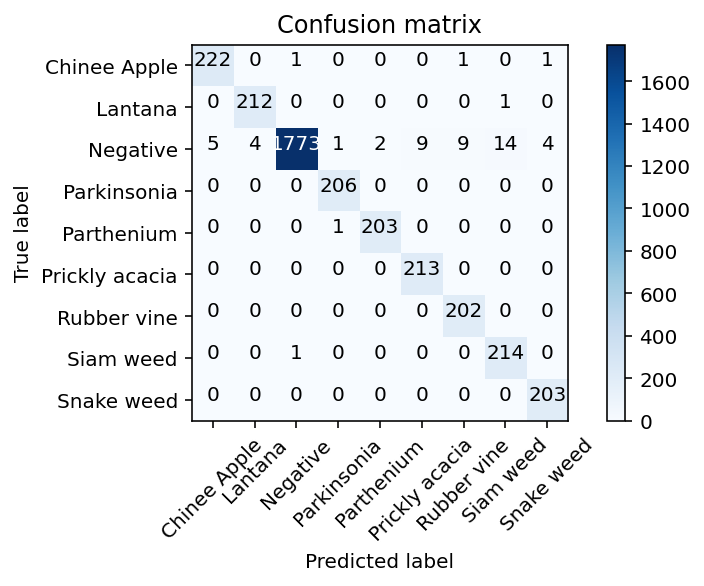

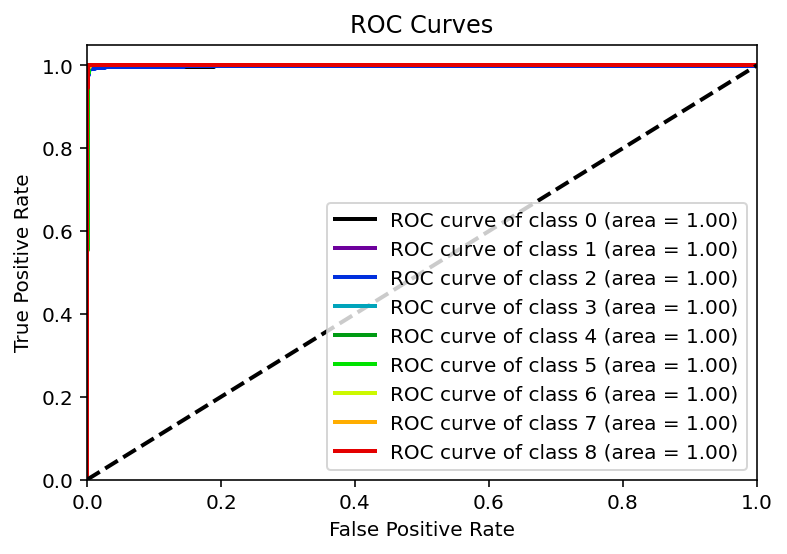

Inference completes in 0m 11s


In [7]:
%time
def compute_validate_meter(model, data_loader): # best_model_path,
    
    since = time.time()
    CHECK_POINT_PATH = '/home/linh/Downloads/DeepWeeds/weights/EfficientNet_B4_SGD.pth'
    #CHECK_POINT_PATH = '/home/linh/Downloads/DeepWeeds/weights/EfficientNet_B4_NS_SGD.pth'

    try:
        checkpoint = torch.load(CHECK_POINT_PATH)
        print("checkpoint loaded")
    except:
        checkpoint = None
        print("checkpoint not found")

    def load_model(best_model_path):                                
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']
    load_model(CHECK_POINT_PATH)
    model.to(device)
    model.eval()
    pred_y = list()
    test_y = list()
    probas_y = list()   
    with torch.no_grad():
        #pbar = tqdm(enumerate(data_loader), total=len(data_loader))
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            data, target = Variable(data), Variable(target)
            output = model(data)
            probas_y.extend(output.data.cpu().numpy().tolist())
            pred_y.extend(output.data.cpu().max(1, keepdim=True)[1].numpy().flatten().tolist())
            test_y.extend(target.data.cpu().numpy().flatten().tolist())
        # compute the confusion matrix
        confusion = confusion_matrix(test_y, pred_y)
        # plot the confusion matrix
        plot_labels = ['Chinee Apple', 'Lantana', 'Negative','Parkinsonia', 'Parthenium', 
                       'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake weed']
     
        plot_confusion_matrix(confusion, plot_labels)
        #plot_confusion_matrix(confusion, classes=val_loader.dataset.classes,title='Confusion matrix')
        # print Recall, Precision, F1-score, Accuracy
        report = classification_report(test_y, pred_y, digits=4)
        print(report)
        plt_roc(test_y, probas_y)
        
    time_elapsed = time.time() - since

    print('Inference completes in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print(count)

#best_model_path = '/home/linh/Downloads/TB/weights/EfficientNet_B1_240.pth'

compute_validate_meter(model, data_loader['test']) #best_model_path,